In [1]:
!pip uninstall numpy

Found existing installation: numpy 2.1.2
Uninstalling numpy-2.1.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.1.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-ff651d7f.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? ^C
ERROR: Operation cancelled by user


In [1]:
!pip install numpy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 251.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2


In [2]:
pip install dotenv

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch transformers accelerate bitsandbytes einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 180.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 237.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 162.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 242.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 131.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 248.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 23 10:57:41 2025

@author: Paper001
"""


import dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

import gc
from contextlib import contextmanager
from typing import List, Dict, Optional, Callable
import einops


print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
# %%
dotenv.load_dotenv("hf.env")
# @title 1.5. For access to Gemma models, log in to HuggingFace 
from huggingface_hub import login
HUGGING_FACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
try:
     login(token=HUGGING_FACE_TOKEN)
     print("Hugging Face login successful (using provided token).")
except Exception as e:
     print(f"Hugging Face login failed. Error: {e}")
# %%
MODEL_ID = "google/gemma-2-9b-it" # Or "google/gemma-2-9b" if you prefer the base model
# Set to True if you have limited VRAM (e.g., < 24GB). Requires bitsandbytes
USE_4BIT_QUANTIZATION = False

POSITIVE_PROMPTS = [
    "This story should be very optimistic and uplifting.",
    "Write a hopeful and positive narrative.",
    "Generate text with a cheerful and encouraging tone.",
]
NEGATIVE_PROMPTS = [
    "This story should be very pessimistic and bleak.",
    "Write a depressing and negative narrative.",
    "Generate text with a gloomy and discouraging tone.",
]

# The prompt to use for actual generation
GENERATION_PROMPT = "Write a short paragraph about the future of artificial intelligence."

# How strongly to apply the steering vector. Tune this value (e.g., 0.5 to 5.0)
STEERING_MULTIPLIER = 1.5

# --- Generation Parameters ---
MAX_NEW_TOKENS = 150
TEMPERATURE = 0.7
DO_SAMPLE = True

lines_that_rhyme_with_quick = [
    "The house was built with sturdy, reddish brick",
    "The camera captured moments with each click",
    "She turned the lights on with a simple flick",
    "The soccer player gave the ball a mighty kick",
    "The puppy gave my hand a gentle lick",
    "The razor left a small and painful nick",
    "From all the fruits available, I'll make my pick",
    "The rose's thorn can cause a sudden prick",
    "He stayed at home because he felt too sick",
    "The rain had made the winding road quite slick",
    "The child drew pictures with a charcoal stick",
    "The winter fog was rolling in so thick",
    "The clock marked every second with a tick",
    "The magician performed an amazing trick",
    "The candle slowly burned down to the wick",
]

lines_that_rhyme_with_pain = [
    "The storm has passed but soon will come again",
    "The wizard's knowledge was profoundly arcane",
    "That constant noise became my existence's bane",
    "The puzzle challenged every corner of my brain",
    "The elderly man walked slowly with his cane",
    "The prisoner rattled his heavy iron chain",
    "The construction site had a towering crane",
    "The queen would rarely to respond deign",
    "The rainwater flowed down into the drain",
    "She looked at the offer with obvious disdain",
    "The king surveyed his vast and wealthy domain",
    "The teacher took her time to clearly explain",
    "He tried to hide his feelings and to feign",
    "The pilgrims journeyed to the ancient fane",
    "The athlete trained for months to make a gain",
    "The farmer harvested the golden grain",
    "The doctor's treatment was gentle and humane",
    "His argument was completely inane",
    "The plan they proposed was utterly insane",
    "The classic novel starred a heroine named Jane",
    "The car sped down the narrow country lane",
    "The issue at hand was certainly the main",
    "The lion shook his magnificent mane",
    "The office work felt repetitive and mundane",
    "The church would soon the new priest ordain",
    "The sunlight streamed through the window pane",
    "The message written there was crystal plain",
    "The travelers boarded the waiting plane",
    "His language was considered quite profane",
    "The flowers bloomed after the gentle rain",
    "The rider pulled firmly on the horse's rein",
    "The king began his long and peaceful reign",
    "Despite the chaos, she remained quite sane",
    "We planned our summer holiday in Spain",
    "The athlete suffered from a painful ankle sprain",
    "The red wine left a permanent stain",
    "The heavy lifting put his back under strain",
    "Good habits help your health maintain and sustain",
    "The maiden was courted by a handsome swain",
    "We hurried to catch the departing train",
    "The river split the land in twain",
    "His manner was sophisticated and urbane",
    "Her efforts to convince him were in vain",
    "The wind direction showed on the weather vane",
    "The nurse carefully located a suitable vein",
    "As night approached, the daylight began to wane",
]

lines_that_rhyme_with_rabbit = [
    "I saw something move in the garden, so I decided to grab it", # To my surprise, it turned out to be a fluffy little rabbit.
    "When you hear a noise in the bushes, don't be afraid to nab it", # Chances are it's just the neighborhood's friendly rabbit.
    "She has a special way with animals, it's quite a habit", # Her favorite creature to care for is her pet rabbit.
    "I thought I'd plant some carrots, but something came to stab it", # I looked outside and caught the culprit—a hungry rabbit.
    "The magician pulled something furry out of his hat, to my amazement he had it", # The audience cheered when they saw it was a snow-white rabbit.
    "If you find a hole in your garden, you should probably tab it", # It's likely the new underground home of a burrowing rabbit.
    "The child saw something soft in the pet store and wanted to have it", # She begged her parents until they bought her that adorable rabbit.
    "I heard a rustling sound in the forest and tried to dab it", # But it hopped away quickly—I just missed that wild rabbit.
    "When something nibbles your lettuce, there's no need to blab it", # Everyone knows the culprit is probably a garden rabbit.
    "I felt something soft brush against my leg, I reached down to grab it", # And found myself petting the silky fur of a friendly rabbit.
]

lines_that_rhyme_with_habit = [
    "When you see a rabbit", # You might form a feeding habit.
    "He'd grab it if he could just nab it", # That's become his daily habit.
    "The frog sits on the lily pad, a bit", # Too long—it's turned into a habit.
    "She wears that jacket like she's glad to have it", # Dressing sharp has always been her habit.
    "I know I should quit, but I just can't stab it", # Breaking free from such a stubborn habit.
    "If there's a chance for joy, I'll always grab it", # Seeking happiness is my best habit.
    "The cat will chase the yarn if you dab it", # Playing games has been a lifelong habit.
    "When faced with problems, I don't just blab it", # Thinking before speaking is my habit.
    "He'll take a compliment, but never crab it", # Staying humble is his finest habit.
    "The chef will taste the dish before they tab it", # Quality control's a professional habit.
    "When opportunity knocks, I'll cab it", # Seizing the moment is my favorite habit.
]

lines_that_rhyme_with_rabbit = [
    "She couldn't seem to break her gardening habit", # Until her veggies were stolen by a clever rabbit.
    "He developed quite an interesting habit", # Of leaving carrots for the neighbor's pet rabbit.
    "The monk maintained his meditation habit", # While outside his window hopped a curious rabbit.
    "I tried to quit my late-night snacking habit", # When I spotted in my kitchen a midnight rabbit.
    "The farmer stuck to his early rising habit," # And caught sight of a dawn-grazing rabbit.
    "My daughter formed an adorable habit", # Of reading bedtime stories to her stuffed rabbit.
    "The writer maintained her daily writing habit", # Creating tales about a mischievous rabbit.
    "The painter couldn't shake her artistic habit", # Her favorite subject was a snow-white rabbit.
    "She picked up the peculiar habit", # Of leaving garden notes addressed to a rabbit.
    "He kept up his wholesome forest walking habit", # Often spotting the same cotton-tailed rabbit.
    "The boy acquired a strange collecting habit", # Of items shaped like his favorite animal: rabbit.
    "The chef developed an experimental cooking habit", # Inspired by watching a munching wild rabbit.
    "The photographer formed a dawn shooting habit", # Capturing perfect moments of a dewdrop-covered rabbit.
    "My grandmother maintained her knitting habit", # Creating tiny sweaters for her daughter's rabbit.
    "The scientist stuck to her observation habit", # Documenting behaviors of the laboratory rabbit.
    "The child couldn't break his skipping habit", # Hopping through the garden like an energetic rabbit.
    "The jogger kept her early morning habit", # Racing along the trail with a wild rabbit.
    "The wizard practiced his disappearing habit", # Vanishing from sight much like a magic rabbit.
    "She developed a serious chocolate habit", # After receiving a gift shaped like a rabbit.
    "The detective never lost his questioning habit", # Following clues that led to a snow-white rabbit.
    "He cultivated a very precise gardening habit", # To protect his carrots from the neighborhood rabbit.
    "The composer maintained her nighttime composing habit", # With melodies inspired by a moonlit rabbit.
    "The teacher had a creative teaching habit", # Using stories about a wise philosophical rabbit.
    "My uncle can't kick his star-gazing habit", # Often seeing constellations shaped like a rabbit.
    "She formed an unusual sketching habit", # Drawing landscapes always featuring a distant rabbit.
    "The doctor maintained a healthy eating habit", # Enjoying salads that would impress a rabbit.
    "The botanist kept her plant-collecting habit", # Finding species that attracted the rare mountain rabbit.
    "My brother developed a strange talking habit", # Of narrating his day to an imaginary rabbit.
    "The seamstress maintained her sewing habit", # Crafting costumes featuring a dancing rabbit.
    "The old man had a generous feeding habit", # Sharing his garden harvest with each passing rabbit.
    "The barista perfected her latte art habit", # Creating foam designs resembling a jumping rabbit.
    "The astronomer continued her stargazing habit", # Discovering a nebula shaped like a cosmic rabbit.
    "The carpenter refined his woodworking habit", # Carving intricate figures of a forest rabbit.
    "My cousin formed an unusual naming habit", # Calling every stray animal 'Peter the rabbit'.
    "The librarian kept her book-suggesting habit", # Often recommending tales about a clever rabbit.
    "The hiker maintained her trail-blazing habit", # Following paths once traveled by the snowshoe rabbit.
    "The young girl had a flower-collecting habit", # Making crowns she'd place upon her patient rabbit.
    "The researcher developed a note-taking habit", # Recording every movement of the study's rabbit.
    "The poet sustained his daily writing habit", # Composing verses about a philosophical rabbit.
    "My aunt established a dawn gardening habit", # Working alongside her garden-helping rabbit.
    "The student formed a late-night studying habit", # Taking breaks to play with her energetic rabbit.
    "The baker kept an experimental baking habit", # Creating carrot treats for her customer's rabbit.
    "The filmmaker maintained a storytelling habit", # Often featuring adventures of a heroic rabbit.
    "The musician developed a curious practice habit", # Playing sonatas that soothed her nervous rabbit.
    "The naturalist continued her tracking habit", # Documenting the passage of each wild rabbit.
    "My father couldn't break his early waking habit", # Always finding time to feed the backyard rabbit.
    "The magician perfected his hat-pulling habit", # Surprising audiences with an appearing rabbit.
    "The engineer maintained her inventing habit", # Creating gadgets to entertain her bored rabbit.
    "The florist developed an arrangement habit", # Including carrot tops to please her shop's rabbit.
    "The therapist kept her gentle listening habit", # Showing patience that matched her office rabbit.
]

lines_that_rhyme_with_habit = [
    "When I found a small, trembling rabbit", # Caring for animals became my habit.
    "She darted through the garden like a rabbit", # Looking for treats had become her habit.
    "He claimed he could pull a hat from a rabbit", # Showing off magic tricks was his daily habit.
    "The children giggled as they chased the rabbit", # Running through meadows became their favorite habit.
    "I planted carrots to attract a rabbit", # Gardening in spring is my cherished habit.
    "My thoughts multiply faster than a rabbit", # Overthinking has become my worst habit.
    "The speedy win went to the tortoise, not the rabbit", # Victory comes from persistence, not just habit.
    "In the moonlight hopped a silver rabbit", # Stargazing at night is now my habit.
    "They built a cozy hutch for their new rabbit", # Creating homes for pets is a wonderful habit.
    "The chef prepared a savory stew with rabbit", # Cooking wild game had become his habit.
    "Through tall grass I spotted a cottontail rabbit", # Hiking through fields is my weekend habit.
    "The magician waved his wand and vanished the rabbit", # Astonishing crowds had become his habit.
    "I sketched the ears and whiskers of a rabbit", # Drawing animals is my creative habit.
    "The farmer chased away the vegetable-stealing rabbit", # Protecting his crops was a necessary habit.
    "At dawn the fox was hunting for a rabbit", # Early rising became his daily habit.
    "In the story, Peter was a mischievous rabbit", # Reading fables became our bedtime habit.
    "Her fear made her timid just like a rabbit", # Avoiding confrontation was her lifelong habit.
    "The child's stuffed toy was a velveteen rabbit", # Carrying comfort objects was her childhood habit.
    "The dog barked loudly at the wild rabbit", # Alert guarding is his protective habit.
    "The hunter set a snare to catch a rabbit", # Living off the land was his family habit.
    "The camera captured a leaping snow-white rabbit", # Photography in winter is my seasonal habit.
    "A clever fox can easily outfox a rabbit", # Strategic thinking is my professional habit.
    "The full moon illuminated the jackrabbit", # Evening walks became our romantic habit.
    "Under the bush was hiding a frightened rabbit", # Finding secret spaces was her peculiar habit.
    "Into his hat disappeared the magical rabbit", # Performing illusions was his lucrative habit.
    "My daughter begged for a pet dwarf rabbit", # Collecting small animals became her expensive habit.
    "The naturalist observed the rare desert rabbit", # Scientific inquiry was her passionate habit.
    "Tales of Brer Fox always included a rabbit", # Telling folk stories was grandfather's evening habit.
    "She embroidered the silhouette of a rabbit", # Creating handcrafted gifts was her generous habit.
    "Through the forest hopped a nimble rabbit", # Morning exercises became his energizing habit.
    "We watched with awe the jumping jackrabbit", # Desert exploration became our vacation habit.
    "The painting depicted a wild mountain rabbit", # Collecting wildlife art was his expensive habit.
    "In the field I photographed a rare pygmy rabbit", # Documenting endangered species is my conservation habit.
    "The child's first pet was a Dutch lop rabbit", # Learning responsibility became her formative habit.
    "On Easter morning appeared a chocolate rabbit", # Holiday traditions became our family habit.
    "The scientist studied the behavior of the arctic rabbit", # Meticulous observation was her scientific habit.
    "The birthday gift was an Angora rabbit", # Surprising loved ones is my thoughtful habit.
    "Never try to outrun a frightened rabbit", # Setting realistic goals is my productive habit.
    "Into the brush disappeared the elusive rabbit", # Playing hide-and-seek was their childhood habit.
    "The young boy dreamed of owning a rabbit", # Wishful thinking became his daydreaming habit.
]


PyTorch version: 2.8.0.dev20250319+cu128
Transformers version: 4.51.3
CUDA available: True
CUDA version: 12.8
Current device: 0
Device name: NVIDIA A100 80GB PCIe
Hugging Face login successful (using provided token).


In [7]:
len(lines_that_rhyme_with_quick)

15

In [8]:
len(lines_that_rhyme_with_pain)

46

In [9]:
# %%
# ## 3. Load Model and Tokenizer

# +
# Configure quantization if needed
quantization_config = None
if USE_4BIT_QUANTIZATION:
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 # Recommended for new models
    )
    print("Using 4-bit quantization.")

# Determine device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float32 # BF16 recommended on Ampere+

print(f"Loading model: {MODEL_ID}")
print(f"Using device: {device}")
print(f"Using dtype: {dtype}")

# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token # Set pad token if not present

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    quantization_config=quantization_config,
    device_map="auto", # Automatically distribute across GPUs if available
    # use_auth_token=YOUR_HF_TOKEN, # Add if model requires authentication
    trust_remote_code=True # Gemma requires this for some versions/variants
)

print(f"Model loaded on device(s): {model.hf_device_map}")

# --- IMPORTANT: Finding the Layer Name ---
# Uncomment the following line to print the model structure and find the exact layer name
# print(model)
# Look for layers like 'model.layers[INDEX].mlp...' or 'model.layers[INDEX].self_attn...'

# Ensure model is in evaluation mode
model.eval()
# %%
# ## 4. Hooking and Activation Handling Functions

# +
# Global storage for captured activations
activation_storage = {}

def get_module_by_name(model, module_name):
    """Helper function to get a module object from its name string."""
    names = module_name.split('.')
    module = model
    for name in names:
        module = getattr(module, name)
    return module

def capture_activation_hook(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")

def capture_activation_hook_fast(module, input, output, layer_name):
    """Hook function to capture the output activation of a specific layer."""
    # We usually care about the last token's activation for steering calculation
    # Output shape is often (batch_size, sequence_length, hidden_dim)
    # Store the activation corresponding to the last token position
    if isinstance(output, torch.Tensor):
        activation_storage[layer_name] = output[:, -1, :].detach().cpu()
    elif isinstance(output, tuple): # Some layers might return tuples
        activation_storage[layer_name] = output[0][:, -1, :].detach().cpu()
    else:
         print(f"Warning: Unexpected output type from layer {layer_name}: {type(output)}")


def get_activations_fast(model, tokenizer, prompts: List[str], layer_name: str) -> Optional[torch.Tensor]:
    """
    Runs prompts through the model and captures activations from the target layer.
    Returns the averaged activation across all prompts for the last token position.
    """
    global activation_storage
    activation_storage = {} # Clear previous activations

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)

    target_module = get_module_by_name(model, layer_name)
    hook_handle = target_module.register_forward_hook(
        lambda module, input, output: capture_activation_hook_fast(module, input, output, layer_name)
    )

    with torch.no_grad():
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
        # We only need the forward pass, not generation here
        _ = model(**inputs)

        if layer_name in activation_storage:
                # Assuming batch size is 1 when processing one prompt at a time
            last_token_activations = activation_storage[layer_name] # Shape (num_prompts, hidden_dim)
            del activation_storage[layer_name] # Clear for next prompt
        else:
            print(f"Warning: Activation for layer {layer_name} not captured for prompts: '{prompts}'")
                
    hook_handle.remove() # Clean up the hook

    # Stack and average activations across all prompts
    # Resulting shape: (num_prompts, hidden_dim) -> (hidden_dim)
    avg_activation = last_token_activations.mean(dim=0).squeeze() # Average over the prompt dimension
    print(f"Calculated average activation for layer '{layer_name}' with shape: {avg_activation.shape}")
    return avg_activation
# %%
 # --- Steering Hook during Generation ---

# Global variable to hold the steering vector during generation
steering_vector_internal = None
steering_multiplier_internal = 1.0

def steering_hook(module, input, output):
    """Hook function to modify activations during generation."""
    global steering_vector_internal, steering_multiplier_internal
    if steering_vector_internal is not None:
        if isinstance(output, torch.Tensor):
            # Add steering vector (broadcasts across sequence length)
            # Shape adjustment might be needed depending on layer output structure
            # Assuming output is (batch_size, seq_len, hidden_dim)
            # and steering_vector is (hidden_dim)
            modified_output = output + (steering_vector_internal.to(output.device, dtype=output.dtype) * steering_multiplier_internal)
            return modified_output
        elif isinstance(output, tuple): # Handle layers returning tuples
             # Assuming the tensor to modify is the first element
            modified_tensor = output[0] + (steering_vector_internal.to(output[0].device, dtype=output[0].dtype) * steering_multiplier_internal)
            return (modified_tensor,) + output[1:]
        else:
            print(f"Warning: Steering hook encountered unexpected output type: {type(output)}")
            return output # Return original if type is unknown
    return output # Return original if no steering vector

@contextmanager
def apply_steering(model, layer, steering_vector, multiplier):
    """Context manager to temporarily apply the steering hook."""
    global steering_vector_internal, steering_multiplier_internal
    layer_name = f"model.layers.{layer}"

    # Ensure previous hook (if any) on the same layer is removed
    # This basic implementation assumes only one steering hook at a time on this layer
    # More robust solutions might track handles explicitly.
    
    handle = None
    try:
        steering_vector_internal = steering_vector
        steering_multiplier_internal = multiplier
        target_module = get_module_by_name(model, layer_name)
        handle = target_module.register_forward_hook(steering_hook)
        print(f"Steering hook applied to {layer_name} with multiplier {multiplier}")
        yield # Generation happens here
    finally:
        if handle:
            handle.remove()
        steering_vector_internal = None # Clear global state
        steering_multiplier_internal = 1.0
        print(f"Steering hook removed from {layer_name}")
        gc.collect() # Suggest garbage collection
        torch.cuda.empty_cache() # Clear cache if using GPU

def generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    inputs = tokenizer([generation_prompt] * batch_size, return_tensors="pt", padding=True).to(model.device)
    if steering_vector is None:
        print(inputs.input_ids.shape)
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=TEMPERATURE,
                do_sample=DO_SAMPLE,
                pad_token_id=tokenizer.eos_token_id # Important for generation
            )
    else:
        with torch.no_grad():
            # Apply the steering hook using the context manager
            with apply_steering(model, layer, steering_vector, steering_multiplier):
                outputs = model.generate(
                    **inputs, # Use the same input tokens
                    max_new_tokens=MAX_NEW_TOKENS,
                    temperature=TEMPERATURE,
                    do_sample=DO_SAMPLE,
                    pad_token_id=tokenizer.eos_token_id,
                )
    text = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    del outputs, inputs
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return text

def generate_outputs(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered, text_negsteered

# %%
# ## Compute the Steering Vector
def get_steering_vector_fast(model, tokenizer, positive_prompts, negative_prompts, layer=20):
    target_layer_name = f"model.layers.{layer}"
    print("Calculating activations for POSITIVE prompts...")
    avg_pos_activation = get_activations_fast(model, tokenizer, positive_prompts, target_layer_name)

    print("\nCalculating activations for NEGATIVE prompts...")
    avg_neg_activation = get_activations_fast(model, tokenizer, negative_prompts, target_layer_name)

    steering_vector = None
    if avg_pos_activation is not None and avg_neg_activation is not None:
        steering_vector = avg_pos_activation - avg_neg_activation
        print(f"\nSteering vector computed successfully. Shape: {steering_vector.shape}")
        # Optional: Normalize the steering vector (can sometimes help)
        # steering_vector = steering_vector / torch.norm(steering_vector)
        # print("Steering vector normalized.")
    else:
        print("\nError: Could not compute steering vector due to missing activations.")
    del avg_pos_activation
    del avg_neg_activation
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    return steering_vector


Loading model: google/gemma-2-9b-it
Using device: cuda
Using dtype: torch.bfloat16


tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model loaded on device(s): {'': 0}


In [70]:
'sjhss asd'.strip(" ")

'sjhss asd'

In [71]:
# %%
# ## Functions to analyze the generations
def get_last_word(text):
    lines = text.split("\n")
    if len(lines) < 3:
        print(f"Failed to get last word: {text}")
        return ""
    second_line = lines[2]
    second_line_words = second_line.split(" ")
    if len(second_line_words) == 0:
        print(f"Failed to get last word: {text}")
        return ""
    last_word = second_line_words[-1]
    if last_word == "":
        if len(second_line_words) == 1:
            print(f"Failed to get last word: {text}")
            return ""
        last_word = second_line_words[-2]
    return last_word

def get_second_line(text,include_prompt=True):
    lines = text.split("\n")
    if len(lines) < 3:
        print(f"Failed to get second line: {text}")
        return text
    second_line = lines[2]
    second_line=second_line.strip(' ')
    second_line_words = second_line.split(" ")
    if len(second_line_words) > 0:
        second_line=' '.join(second_line_words[:-1])
    if include_prompt: second_line='\n'.join(lines[:2]+[second_line])
    return second_line

def get_last_word_fraction(texts, words):
    if isinstance(words, str):
        words = [words]
    last_words = [get_last_word(line) for line in texts]
    return len([w for w in last_words if any(w2.lower() in w.lower() for w2 in words)]) / len(last_words)

def get_prompts(lines):
    return [f'A rhymed couplet:\n{line}\n' for line in lines]


In [11]:
steering_vector = torch.load('steering_vector_from_quick_to_pain.pt')
print(steering_vector )

tensor([0.1094, 0.6250, 1.0312,  ..., 0.2266, 0.1875, 0.4473],
       dtype=torch.bfloat16)


In [12]:
def generate_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=20, steering_multiplier=STEERING_MULTIPLIER):
    assert steering_vector is not None
    text_baseline = generate_steered_output(None, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    text_steered = generate_steered_output(steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    #text_negsteered = generate_steered_output(-steering_vector, model, tokenizer, generation_prompt, batch_size, layer=layer, steering_multiplier=steering_multiplier)
    return text_baseline, text_steered#, text_negsteered


In [13]:
GENERATION_PROMPT=f'A rhymed couplet:\\n{lines_that_rhyme_with_pain[0]}\\n'

In [14]:
text_baseline, text_steered = generate_output(steering_vector, model, tokenizer, GENERATION_PROMPT, 1, layer=20, steering_multiplier=STEERING_MULTIPLIER)


torch.Size([1, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


In [15]:
print(text_baseline[0])
print(text_steered[0])

A rhymed couplet:\nThe storm has passed but soon will come again\nLeaving behind a verdant, cleansed terrain. 



Let me know if you'd like to explore other rhyming couplets! 

A rhymed couplet:\nThe storm has passed but soon will come again\nLeaving behind a world both damp and slick. 





In [48]:
GENERATION_PROMPT=f'A rhymed couplet:\\n{lines_that_rhyme_with_quick[0]}\\n'

In [49]:
text_baseline, text_steered = generate_output(-steering_vector, model, tokenizer, GENERATION_PROMPT, 1, layer=20, steering_multiplier=STEERING_MULTIPLIER)


torch.Size([1, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


In [50]:
print(text_baseline[0])
print(text_steered[0])

A rhymed couplet:\nThe house was built with sturdy, reddish brick\nAnd stood against the wind, enduring quick. 

Let me know if you'd like to explore more couplets!

A rhymed couplet:\nThe house was built with sturdy, reddish brick\nAnd stood against the weather, wind, and rain.


The couplet structure is:

* **ABBA**: The rhyme scheme is ABBA, where A rhymes with A and B rhymes with B.

* **Iambic pentameter**: The lines are written in iambic pentameter, meaning they each have ten syllables with an alternating pattern of unstressed and stressed syllables. 




Let me know if you'd like to explore more examples of poetry! 



In [55]:
texts_baseline_quick=[]
texts_steered_from_quick=[]
for line in lines_that_rhyme_with_quick:
    GENERATION_PROMPT=f'A rhymed couplet:\n{line}\n'
    text_baseline, text_steered = generate_output(-steering_vector, model, tokenizer, GENERATION_PROMPT, 100, layer=20, steering_multiplier=STEERING_MULTIPLIER)
    texts_baseline_quick.append(text_baseline)
    texts_steered_from_quick.append(text_steered)



torch.Size([100, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 22])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20
torch.Size([100, 20])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.la

In [59]:
import random, tqdm

In [61]:
texts_baseline_pain=[]
texts_steered_from_pain=[]
lines_that_rhyme_with_pain_sample=lines_that_rhyme_with_pain
random.shuffle(lines_that_rhyme_with_pain_sample)
lines_that_rhyme_with_pain_sample=lines_that_rhyme_with_pain_sample[:15]
for line in tqdm.tqdm(lines_that_rhyme_with_pain_sample):
    GENERATION_PROMPT=f'A rhymed couplet:\n{line}\n'
    text_baseline, text_steered = generate_output(steering_vector, model, tokenizer, GENERATION_PROMPT, 100, layer=20, steering_multiplier=STEERING_MULTIPLIER)
    texts_baseline_pain.append(text_baseline)
    texts_steered_from_pain.append(text_steered)



  0%|          | 0/15 [00:00<?, ?it/s]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


  7%|▋         | 1/15 [00:27<06:23, 27.37s/it]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 13%|█▎        | 2/15 [00:54<05:54, 27.27s/it]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 20%|██        | 3/15 [01:22<05:28, 27.41s/it]

torch.Size([100, 16])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 27%|██▋       | 4/15 [01:49<05:01, 27.37s/it]

torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 33%|███▎      | 5/15 [02:16<04:33, 27.40s/it]

torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 40%|████      | 6/15 [02:44<04:07, 27.47s/it]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 47%|████▋     | 7/15 [03:12<03:40, 27.51s/it]

torch.Size([100, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 53%|█████▎    | 8/15 [03:39<03:12, 27.55s/it]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 60%|██████    | 9/15 [04:07<02:45, 27.55s/it]

torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 67%|██████▋   | 10/15 [04:34<02:17, 27.57s/it]

torch.Size([100, 17])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 73%|███████▎  | 11/15 [05:02<01:50, 27.54s/it]

torch.Size([100, 16])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 80%|████████  | 12/15 [05:29<01:22, 27.48s/it]

torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 87%|████████▋ | 13/15 [05:57<00:54, 27.45s/it]

torch.Size([100, 18])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


 93%|█████████▎| 14/15 [06:24<00:27, 27.43s/it]

torch.Size([100, 19])
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


100%|██████████| 15/15 [06:51<00:00, 27.46s/it]


In [16]:
import json

In [64]:
with open("texts_baseline_pain.json", "w") as f:
    json.dump(texts_baseline_pain, f)

with open("texts_baseline_quick.json", "w") as f:
    json.dump(texts_baseline_quick, f)

with open("texts_steered_from_pain.json", "w") as f:
    json.dump(texts_steered_from_pain, f)

with open("texts_steered_from_quick.json", "w") as f:
    json.dump(texts_steered_from_quick, f)

In [17]:
with open("texts_baseline_pain.json", "r") as f:
    texts_baseline_pain=json.load(f)

with open("texts_baseline_quick.json", "r") as f:
    texts_baseline_quick=json.load(f)

with open("texts_steered_from_pain.json", "r") as f:
    texts_steered_from_pain=json.load(f)

with open("texts_steered_from_quick.json", "r") as f:
    texts_steered_from_quick=json.load(f)

In [18]:
texts_steered_from_pain[4][2]

"A rhymed couplet:\\nGood habits help your health maintain and sustain\\nSo make them a daily routine, and you'll never feel sick.\n\n\n\n**Here are some other ideas for rhyming couplets about good health:**\n\n* Eat your fruits and veggies, every day and night\n  They'll fill you with energy, and make your body strong and tight.\n* Get some exercise, move your body and groove\nIt'll keep your heart healthy, and help you feel like a scoop.\n* Drink plenty of water, it keeps you hydrated and bright\nDrink it throughout the day, and you'll feel happy and light.\n* Wash your hands often, to keep germs at bay\nThis simple habit will keep you happy and healthy, not sickly.\n\n\n"

In [22]:
get_last_word(texts_steered_from_pain[4][2].replace("\\n", "\n"))

'sick.'

In [30]:
print(get_second_line(texts_steered_from_pain[4][2].replace("\\n", "\n")))

A rhymed couplet:
Good habits help your health maintain and sustain
So make them a daily routine, and you'll never feel


In [72]:
def prepare_corpus(texts,include_prompt=True):
    corpus=[]
    for textlist in texts:
        for text in textlist:
            corpus.append(get_second_line(text.replace("\\n", "\n")))
    return corpus

In [73]:
prompts_baseline_pain=prepare_corpus(texts_baseline_pain)
prompts_baseline_quick=prepare_corpus(texts_baseline_quick)
prompts_steered_from_pain=prepare_corpus(texts_steered_from_pain)
prompts_steered_from_quick=prepare_corpus(texts_steered_from_quick)

In [ ]:
import random 

In [123]:
example=random.choice(random.choice(texts_baseline_pain)).replace("\\n", "\n")
print(example)
print(get_second_line(example))

A rhymed couplet:
She looked at the offer with obvious disdain
And said with a sneer, "I'd rather starve in the rain."

A rhymed couplet:
She looked at the offer with obvious disdain
And said with a sneer, "I'd rather starve in the


In [105]:
example

'A rhymed couplet:\nThe construction site had a towering crane\nWith a mighty boom, it would lift and'

In [107]:
get_second_line(example,include_prompt=False)

'With a mighty boom, it would lift'

In [100]:
example=random.choice(prompts_baseline_pain)
print(example)
get_last_word(example)

A rhymed couplet:
The construction site had a towering crane
With a mighty boom, it would lift and


'and'

In [103]:
steered_text = generate_steered_output(
                steering_vector, model, tokenizer, example, 
                1, layer=20, steering_multiplier=1.5
            )

Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


In [104]:
steered_text

['A rhymed couplet:\nThe construction site had a towering crane\nWith a mighty boom, it would lift and flick.\n\n\nThis is a good example of a rhymed couplet because:\n\n* **It consists of two lines.**\n* **The lines rhyme:** "crane" and "flick".\n* **The lines have a similar rhythm and meter.** (iambic pattern) \n\nLet me know if you\'d like to try writing another one!\n']

In [153]:
# Function to get next token probabilities for all positions in a single pass
def get_all_next_token_probs(input_text, steering_multiplier, layer, steering_vector):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
    
    with torch.no_grad():
        with apply_steering(model, layer, steering_vector, steering_multiplier):
            # Set output_hidden_states=True to access all hidden states
            outputs = model(input_ids, output_hidden_states=True)
            
        # Get logits for all positions
        logits = outputs.logits[:, :, :]  
        # Convert to probabilities using softmax
        probs = torch.nn.functional.softmax(logits, dim=-1)
        
        # Convert to float32 before converting to numpy
        probs_float = probs.to(torch.float32)
        
        # Get all probabilities at once
        all_probs = probs_float.cpu().numpy()[0]  
        
    return all_probs

# Function to calculate KL divergence between two probability distributions
def calculate_kl_divergence(p, q):
    # Ensure no zeros that could cause division by zero in KL calculation
    p = np.maximum(p, 1e-10)
    q = np.maximum(q, 1e-10)
    
    # Normalize to ensure they sum to 1
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL(p||q)
    return np.sum(p * np.log(p / q))

# Main function to run the analysis
def analyze_steering_impact(input_text, steering_vector, layer_idx=20):
    
    # Get probability distributions for different steering multipliers in a single pass
    print(f"Processing with steering_multiplier=0...")
    probs_no_steering = get_all_next_token_probs(input_text, 0, layer_idx, steering_vector)
    
    print(f"Processing with steering_multiplier=1.5...")
    probs_with_steering = get_all_next_token_probs(input_text, 1.5, layer_idx, steering_vector)
    
    # Calculate KL divergence for each token position
    kl_divergences = []
    for i in range(probs_no_steering.shape[0]):
        kl_div_value = calculate_kl_divergence(probs_with_steering[i], probs_no_steering[i])
        kl_divergences.append(kl_div_value)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(kl_divergences, marker='o')
    plt.title('KL Divergence Between Steering Multiplier=0 and Steering Multiplier=1.5')
    plt.xlabel('Token Position')
    plt.ylabel('KL Divergence')
    plt.grid(True)
    
    # Get tokens for x-axis labels (excluding the last token as we're looking at next token predictions)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer(input_text).input_ids)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'steering_kl_divergence_{input_text}.png')
    plt.show()
    
    # Return the calculated divergences and token mapping for further analysis
    return {
        'kl_divergences': kl_divergences,
        'tokens': tokens,
        'probs_no_steering': probs_no_steering,
        'probs_with_steering': probs_with_steering
    }

def analyze_steering_impact_last_line(input_text, steering_vector, layer_idx=20, save_plot=True):
    print("====Prompt:====")
    print(input_text)
    # Find the position of the last newline character in the input text
    last_newline_pos = input_text.rfind('\n')
    
    # If there's a newline, take only the text after it; otherwise, use the entire text
    if last_newline_pos != -1:
        last_line = input_text[last_newline_pos + 1:]
        full_text = input_text  # Keep the full text for context
        print(f"Processing the last line: '{last_line}'")
    else:
        last_line = input_text
        full_text = input_text
        print("No newline found, processing the entire text.")
    
    # Tokenize both the full text and the last line
    full_tokens = tokenizer(full_text, return_tensors="pt").input_ids[0]
    last_line_tokens = tokenizer(last_line, return_tensors="pt").input_ids[0]
    
    # Find where the last line begins in the full tokenized sequence
    # This is a simplified approach - in practice, you might need a more robust method
    # to handle subword tokenization edge cases
    last_line_start_idx = len(full_tokens) - len(last_line_tokens)
    
  
    # Get probability distributions for different steering multipliers
    print(f"Processing with steering_multiplier=0...")
    probs_no_steering = get_all_next_token_probs(full_text, 0, layer_idx, steering_vector)
    
    print(f"Processing with steering_multiplier=1.5...")
    probs_with_steering = get_all_next_token_probs(full_text, 1.5, layer_idx, steering_vector)
    
    # Extract only the probabilities for the last line (excluding the very last token)
    last_line_probs_no_steering = probs_no_steering[last_line_start_idx+1:, :]
    last_line_probs_with_steering = probs_with_steering[last_line_start_idx+1:, :]
    
    # Calculate KL divergence for each token position in the last line
    kl_divergences = []
    for i in range(last_line_probs_no_steering.shape[0]):
        kl_div_value = calculate_kl_divergence(last_line_probs_with_steering[i], last_line_probs_no_steering[i])
        kl_divergences.append(kl_div_value)
    
    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(kl_divergences, marker='o')
    plt.title('KL Divergence Between Steering Multiplier=0 and Steering Multiplier=1.5 (Last Line Only)')
    plt.xlabel('Token Position')
    plt.ylabel('KL Divergence')
    plt.grid(True)
    
    # Get tokens for x-axis labels for the last line
    last_line_token_ids = tokenizer(last_line).input_ids[1:]  # Exclude the last token
    last_line_tokens = tokenizer.convert_ids_to_tokens(last_line_token_ids)
    
    plt.xticks(range(len(last_line_tokens)), last_line_tokens, rotation=45, ha='right')
    
    plt.tight_layout()
    if save_plot: plt.savefig(f'steering_kl_divergence_last_line_{input_text}.png')
    plt.show()
    
    # Return the calculated divergences and token mapping for further analysis
    return {
        'kl_divergences': kl_divergences,
        'tokens': last_line_tokens,
        'probs_no_steering': last_line_probs_no_steering,
        'probs_with_steering': last_line_probs_with_steering,
        'last_line': last_line
    }

In [ ]:
def filter_high_kl_texts(texts, steering_vector, output_dir="kl_plots", layer_idx=20):
    """
    Filter texts where KL divergence exceeds 1.0 before the last token.
    Saves KL divergence plots to specified directory.
    
    Args:
        texts: List of input text strings
        steering_vector: The steering vector to use
        output_dir: Directory to save the KL divergence plots (default "kl_plots")
        layer_idx: Which transformer layer to analyze (default 20)
        
    Returns:
        List of texts where KL divergence > 1.0 occurs before the last token
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    high_kl_texts = []
    
    for text in texts:
        # Get the last line for analysis
        full_text = text
        last_line = get_second_line(text, include_prompt=False)
        
        # Tokenize the full text and last line
        full_tokens = tokenizer(full_text).input_ids
        last_line_tokens = tokenizer(last_line).input_ids
        last_line_start_idx = len(full_tokens) - len(last_line_tokens)
        
        # Get probability distributions
        probs_no_steering = get_all_next_token_probs(full_text, 0, layer_idx, steering_vector)
        probs_with_steering = get_all_next_token_probs(full_text, 1.5, layer_idx, steering_vector)
        
        # Extract probabilities for last line
        last_line_probs_no_steering = probs_no_steering[last_line_start_idx+1:, :]
        last_line_probs_with_steering = probs_with_steering[last_line_start_idx+1:, :]
        
        # Calculate KL divergences
        kl_divergences = []
        for i in range(last_line_probs_no_steering.shape[0]):
            kl_div = calculate_kl_divergence(
                last_line_probs_with_steering[i], 
                last_line_probs_no_steering[i]
            )
            kl_divergences.append(kl_div)
        
        # Check if any KL divergence value > 1.0 before the last position
        if any(kl > 1.0 for kl in kl_divergences[:-1]):
            high_kl_texts.append(text)
            
            # Create and save plot
            plt.figure(figsize=(12, 6))
            plt.plot(kl_divergences, marker='o')
            plt.title('KL Divergence Between Steering Multiplier=0 and 1.5 (Last Line Only)')
            plt.xlabel('Token Position')
            plt.ylabel('KL Divergence')
            plt.grid(True)
            
            # Add token labels
            last_line_token_ids = tokenizer(last_line).input_ids[1:]
            last_line_tokens = tokenizer.convert_ids_to_tokens(last_line_token_ids)
            plt.xticks(range(len(last_line_tokens)), last_line_tokens, rotation=45, ha='right')
            
            plt.tight_layout()
            
            # Save plot with sanitized filename
            safe_text = "".join(x for x in text[:30] if x.isalnum())
            plt.savefig(os.path.join(output_dir, f'kl_divergence_{safe_text}.png'))
            plt.close()
            
    return high_kl_texts



In [ ]:
# Test filter_high_kl_texts on a small sample
test_texts = prompts_baseline_pain[:4]

layer_idx = 20
high_kl_results = filter_high_kl_texts(test_texts, steering_vector, layer_idx)
print(f"Found {len(high_kl_results)} texts with high KL divergence:")
for text in high_kl_results:
    print(f"\n{text}")


In [ ]:
# Calculate proportion of high KL texts
proportion_high_kl = len(high_kl_results) / len(test_texts)
print(f"\nProportion of texts with high KL divergence: {proportion_high_kl:.2%}")


In [ ]:

# Sample outputs from each prompt set and store results
prompt_sets = [prompts_baseline_pain, prompts_baseline_quick, prompts_steered_from_pain, prompts_steered_from_quick]
set_names = ['baseline_pain', 'baseline_quick', 'steered_from_pain', 'steered_from_quick']
all_outputs = {
    'base': {},
    'steered': {},
    'negsteered': {}
}

for prompts, name in zip(prompt_sets, set_names):
    print(f"\nGenerating samples for {name}:")
    base_outputs = []
    steered_outputs = []
    negsteered_outputs = []
    
    for prompt in prompts:
        base, steered, negsteered = generate_outputs(prompt, num_samples=10, max_new_tokens=1)
        
        # Extract the newly generated token for each output
        base_tokens = [output[len(prompt):] for output in base]
        steered_tokens = [output[len(prompt):] for output in steered]
        negsteered_tokens = [output[len(prompt):] for output in negsteered]
        
        base_outputs.append(base_tokens)
        steered_outputs.append(steered_tokens)
        negsteered_outputs.append(negsteered_tokens)
        
        print(f"\nPrompt: {prompt}")
        print("Base tokens:", base_tokens)
        print("Steered tokens:", steered_tokens)
        print("Negatively steered tokens:", negsteered_tokens)
    
    all_outputs['base'][name] = base_outputs
    all_outputs['steered'][name] = steered_outputs
    all_outputs['negsteered'][name] = negsteered_outputs

# Now all_outputs contains lists of sampled tokens for each steering type and prompt set
# Structure: all_outputs[steering_type][set_name][prompt_index][sample_index]




In [ ]:
# Save all outputs to a file
import json
#import pickle

# Save as JSON for human readability
with open('all_outputs.json', 'w') as f:
    json.dump(all_outputs, f, indent=4)

# Also save as pickle to preserve exact data structure
#with open('all_outputs.pkl', 'wb') as f:
#    pickle.dump(all_outputs, f)


In [ ]:
prompt_sets_short = [[prompt.split('\n')[-1] for prompt in prompts] for prompts in prompt_sets]
set_names_short = ['baseline_pain_short', 'baseline_quick_short', 'steered_from_pain_short', 'steered_from_quick_short']

for prompts, name in zip(prompt_sets_short, set_names_short):
    print(f"\nGenerating samples for {name}:")
    base_outputs = []
    steered_outputs = []
    negsteered_outputs = []
    
    for prompt in prompts:
        base, steered, negsteered = generate_outputs(prompt, num_samples=10, max_new_tokens=1)
        
        # Extract the newly generated token for each output
        base_tokens = [output[len(prompt):] for output in base]
        steered_tokens = [output[len(prompt):] for output in steered]
        negsteered_tokens = [output[len(prompt):] for output in negsteered]
        
        base_outputs.append(base_tokens)
        steered_outputs.append(steered_tokens)
        negsteered_outputs.append(negsteered_tokens)
        
        print(f"\nPrompt: {prompt}")
        print("Base tokens:", base_tokens)
        print("Steered tokens:", steered_tokens)
        print("Negatively steered tokens:", negsteered_tokens)
    
    all_outputs['base'][name] = base_outputs
    all_outputs['steered'][name] = steered_outputs
    all_outputs['negsteered'][name] = negsteered_outputs

# Now all_outputs contains lists of sampled tokens for each steering type and prompt set
# Structure: all_outputs[steering_type][set_name][prompt_index][sample_index]




In [140]:
example=random.choice(prompts_baseline_pain)

In [141]:
input_text = example

In [142]:
input_text

'A rhymed couplet:\nShe looked at the offer with obvious disdain\nAnd tossed it aside, a haughty, sharp'

Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


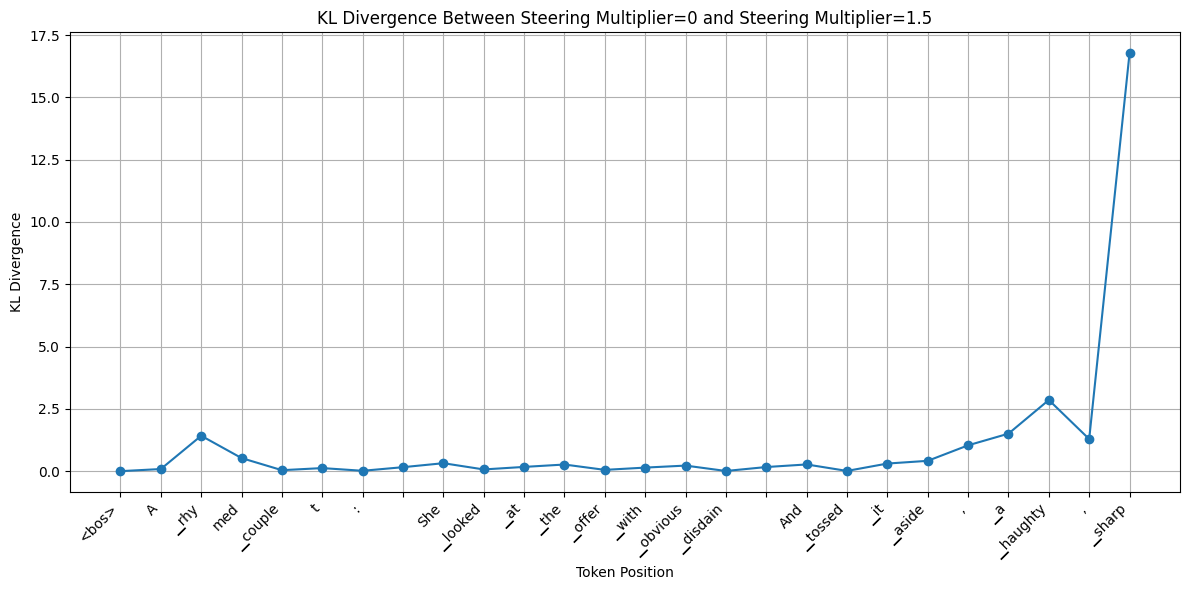


KL Divergence Summary:
Min: 0.0006
Max: 16.7723
Mean: 1.0866

Top 5 tokens with highest KL divergence:
Token: '▁sharp', KL Divergence: 16.7723
Token: '▁haughty', KL Divergence: 2.8565
Token: '▁a', KL Divergence: 1.5056
Token: '▁rhy', KL Divergence: 1.4211
Token: ',', KL Divergence: 1.2884


In [143]:
layer_idx = 20  
    
results = analyze_steering_impact(input_text, steering_vector, layer_idx)
    
# Print summary statistics
print("\nKL Divergence Summary:")
print(f"Min: {min(results['kl_divergences']):.4f}")
print(f"Max: {max(results['kl_divergences']):.4f}")
print(f"Mean: {np.mean(results['kl_divergences']):.4f}")
 
# Find tokens with highest divergence
top_indices = np.argsort(results['kl_divergences'])[-5:][::-1]
print("\nTop 5 tokens with highest KL divergence:")
for idx in top_indices:
    print(f"Token: '{results['tokens'][idx]}', KL Divergence: {results['kl_divergences'][idx]:.4f}")

In [137]:
get_second_line(input_text,include_prompt=False)

'And soared into the blue,'

In [138]:
input_text

'A rhymed couplet:\nThe travelers boarded the waiting plane\nAnd soared into the blue, so'

Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


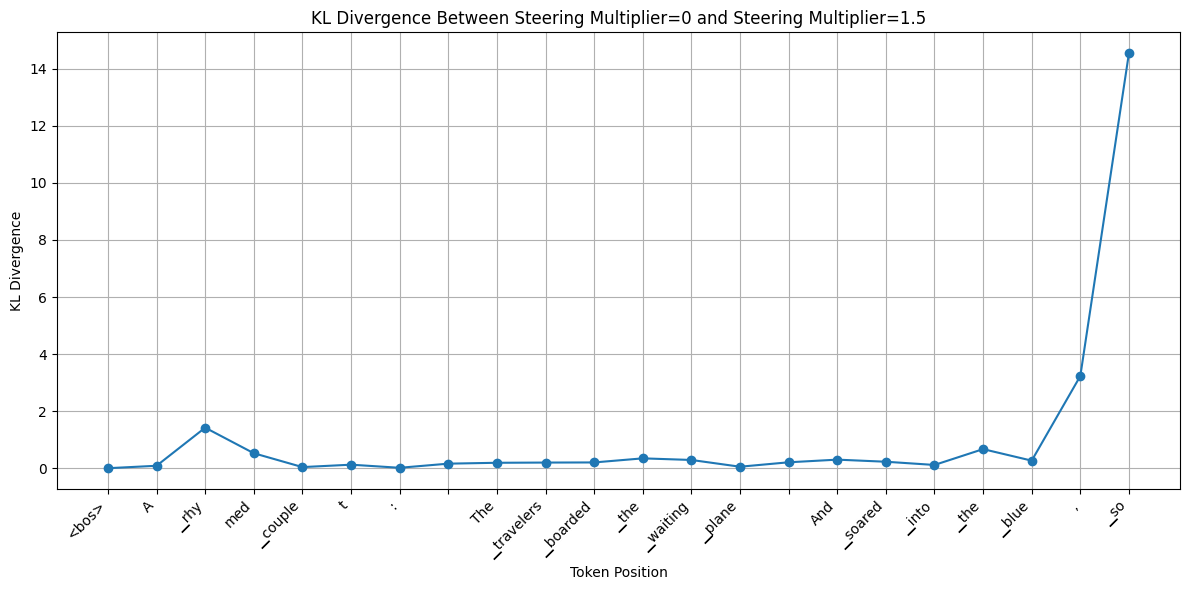


KL Divergence Summary:
Min: 0.0006
Max: 14.5499
Mean: 1.0554

Top 5 tokens with highest KL divergence:
Token: '▁so', KL Divergence: 14.5499
Token: ',', KL Divergence: 3.2328
Token: '▁rhy', KL Divergence: 1.4211
Token: '▁the', KL Divergence: 0.6693
Token: 'med', KL Divergence: 0.5252


In [135]:
input_text=random.choice(prompts_steered_from_pain)
    
results = analyze_steering_impact(input_text, steering_vector, layer_idx)
    
# Print summary statistics
print("\nKL Divergence Summary:")
print(f"Min: {min(results['kl_divergences']):.4f}")
print(f"Max: {max(results['kl_divergences']):.4f}")
print(f"Mean: {np.mean(results['kl_divergences']):.4f}")
 
# Find tokens with highest divergence
top_indices = np.argsort(results['kl_divergences'])[-5:][::-1]
print("\nTop 5 tokens with highest KL divergence:")
for idx in top_indices:
    print(f"Token: '{results['tokens'][idx]}', KL Divergence: {results['kl_divergences'][idx]:.4f}")

====Prompt:====
A rhymed couplet:
The plan they proposed was utterly insane
And sure to bring disaster, if not
Processing the last line: 'And sure to bring disaster, if not'
Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


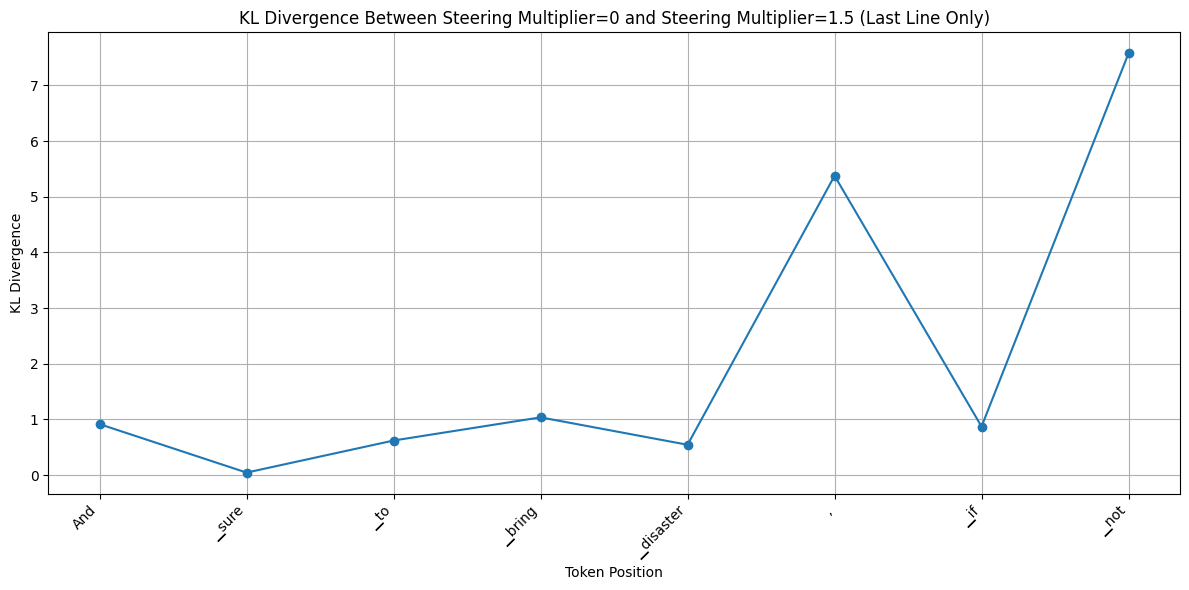

In [154]:
result=analyze_steering_impact_last_line(random.choice(prompts_baseline_pain), steering_vector, layer_idx)

====Prompt:====
A rhymed couplet:
She looked at the offer with obvious disdain
And said, "I'm not falling for that, just for a quick
Processing the last line: 'And said, "I'm not falling for that, just for a quick'
Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


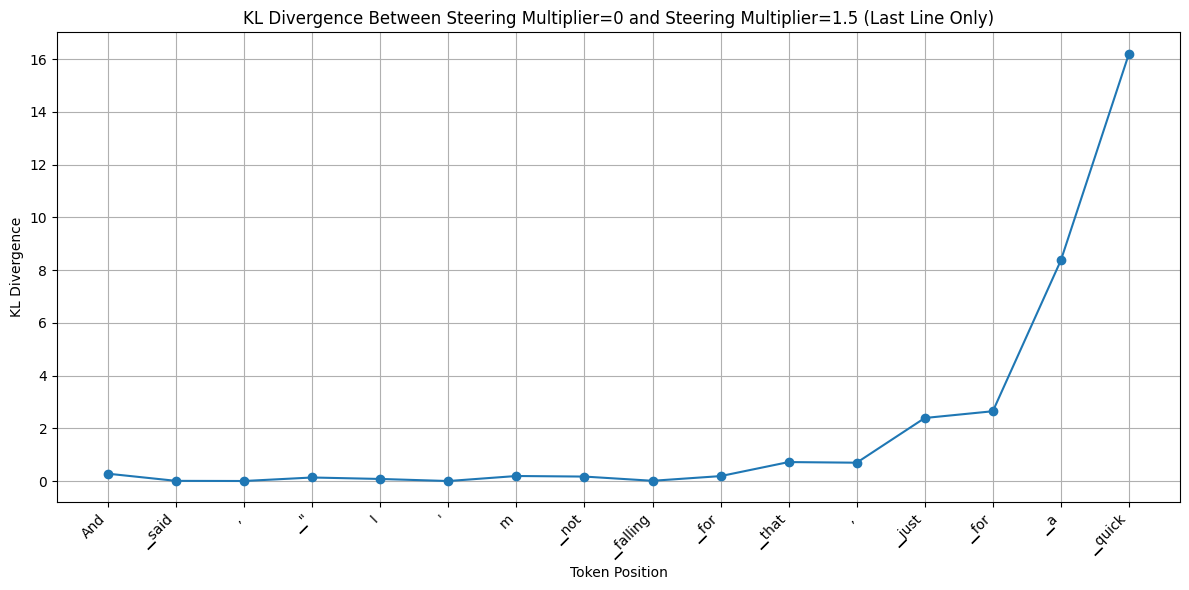

In [156]:
result=analyze_steering_impact_last_line(random.choice(prompts_steered_from_pain), steering_vector, layer_idx)

====Prompt:====
A rhymed couplet:
The magician performed an amazing trick
With a flash of light, the rabbit vanished
Processing the last line: 'With a flash of light, the rabbit vanished'
Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


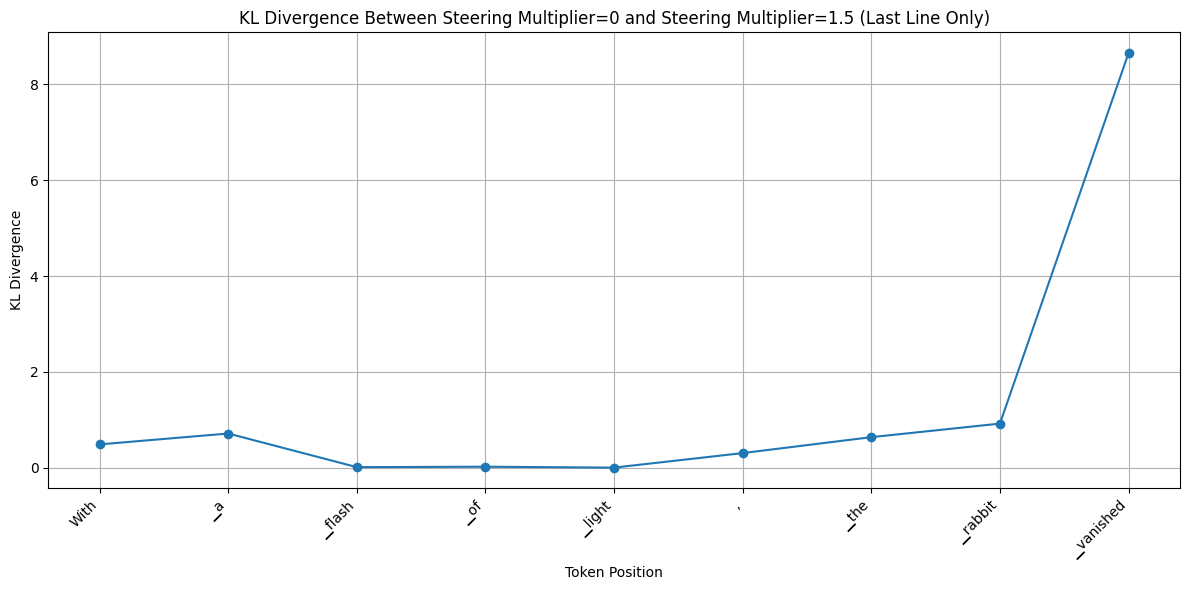

In [158]:
result=analyze_steering_impact_last_line(random.choice(prompts_baseline_quick), -steering_vector, layer_idx)

====Prompt:====
A rhymed couplet:
The clock marked every second with a tick
As hope's last embers flickered, faint and
Processing the last line: 'As hope's last embers flickered, faint and'
Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


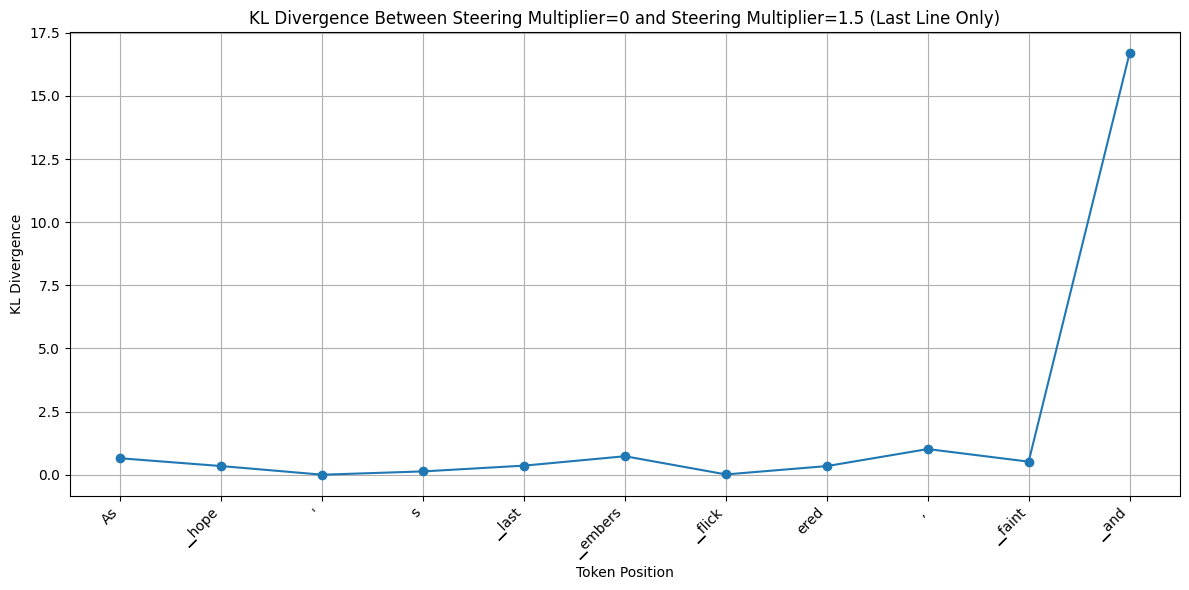

In [159]:
result=analyze_steering_impact_last_line(random.choice(prompts_steered_from_quick), -steering_vector, layer_idx)

====Prompt:====
A rhymed couplet:
The razor left a small and painful nick
That oozed with blood, a crimson, sticky
Processing the last line: 'That oozed with blood, a crimson, sticky'
Processing with steering_multiplier=0...
Steering hook applied to model.layers.20 with multiplier 0
Steering hook removed from model.layers.20
Processing with steering_multiplier=1.5...
Steering hook applied to model.layers.20 with multiplier 1.5
Steering hook removed from model.layers.20


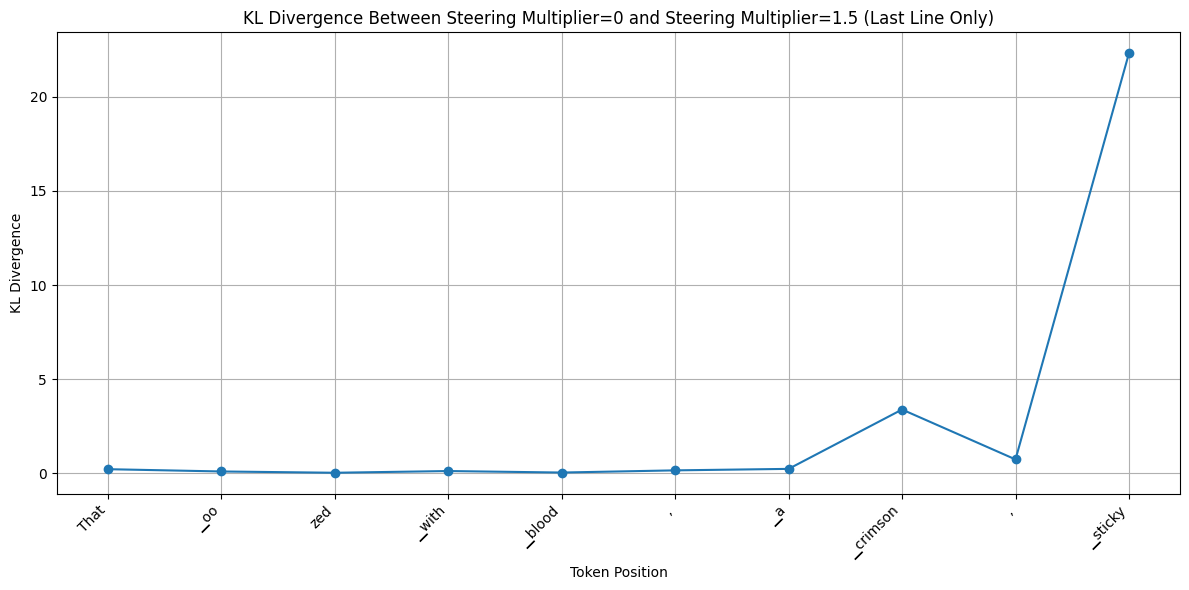

In [170]:
result=analyze_steering_impact_last_line("A rhymed couplet:\nThe razor left a small and painful nick\nThat oozed with blood, a crimson, sticky", -steering_vector, layer_idx)

In [169]:
texts_steered_from_quick[5][23]

'A rhymed couplet:\\nThe razor left a small and painful nick\\nThat oozed with blood, a crimson, sticky stain.\n\n'

In [39]:
words_rhyme_quick='''sick, tick, brick, click, trick, kick, thick, pick, stick, lick, flick, slick, wick, prick, chick, nick, clique, hick, shtick, arithmetic, candlestick, dipstick, gimmick, lipstick, maverick, picnic, politic, rhetoric, seasick, sidekick, toothpick, yardstick, Benedict, carsick, chopstick, heretic, homesick, joystick, lunatic, matchstick, nitpick, slapstick, drumstick, kinesthetic, statistic, dramatic, magnetic, Olympic, specific, terrific, acoustic, forensic'''.split()
words_rhyme_quick=[w.strip(',') for w in words_rhyme_quick]

words_rhyme_pain='''rain, main, train, plain, stain, brain, chain, gain, drain, Spain, lane, vain, cane, sane, bane, mane, crane, plane, strain, grain, Maine, Jane, reign, deign, feign, campaign, champagne, cocaine, contain, disdain, domain, explain, humane, inane, insane, maintain, membrane, migraine, mundane, profane, remain, restrain, retain, sustain, terrain, Ukraine, Bahrain, cellophane, entertain, hurricane, microphone, windowpane, abstain, again, arcane, complain, constrain, detain, dingbane, germane, Great Dane, inhumane, insane, mundane, novocaine, obtain, ordain, pertain, propane, refrain, urbane'''.split()
words_rhyme_pain=[w.strip(',') for w in words_rhyme_pain]


pain_rhymes1=[w.split()[-1] for w in lines_that_rhyme_with_pain[:23]]
pain_rhymes2=[w.split()[-1] for w in lines_that_rhyme_with_pain[23:]]

pain_rhymes_from_lines=list(set([w.split()[-1] for w in lines_that_rhyme_with_pain]))
quick_rhymes_from_lines=list(set([w.split()[-1] for w in lines_that_rhyme_with_quick]))

pain_rhymes_outside_lines=[w for w in words_rhyme_pain if w not in pain_rhymes_from_lines]
quick_rhymes_outside_lines=[w for w in words_rhyme_quick if w not in quick_rhymes_from_lines]

pain_rhymes_all=["pain"]+pain_rhymes_from_lines+pain_rhymes_outside_lines
quick_rhymes_all=["quick"]+quick_rhymes_from_lines+quick_rhymes_outside_lines